In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle, warnings, sys
warnings.filterwarnings('ignore')

from trip_assignment import *
from trip_generation import *
from trip_distribution import *
from mode_split import *
from luti_run import *
from hh_updating import *

In [2]:
dat = gpd.read_file("inputs/zone_data.gpkg")
zone_codes = dat['ZONE_CODE'].tolist()
attraction_predictors = ['JOBS', 'GREEN_DENSITY']
production_predictors = ['POPULATION']

In [17]:
dat.head()

,ZONE_CODE,BASELINE_GREEN_DENSITY,BASELINE_POPULATION,BASELINE_JOBS,OBSERVED_PRODUCTION,OBSERVED_ATTRACTION,BASELINE_CAR_OWNERSHIP,geometry
0,21,0.022870,750,275,600,600,0.81,"POLYGON ((103.79 1.3062, 103.78 1.2967, 103.79..."
1,38,1.225361,390,750,200,366,0.10,"POLYGON ((103.83 1.2729, 103.84 1.2694, 103.85..."
2,50,1.055031,309,750,514,224,0.83,"POLYGON ((103.87 1.2848, 103.87 1.2978, 103.86..."
3,51,0.091703,290,750,348,232,0.84,"POLYGON ((103.82 1.3121, 103.81 1.3026, 103.81..."
4,64,1.176581,311,750,238,478,0.33,"POLYGON ((103.83 1.2469, 103.84 1.2563, 103.84..."


In [3]:
# Load road and bike networks
road_edges = gpd.read_file("inputs/roadNt_edges.gpkg")
road_nodes = gpd.read_file("inputs/roadNt_nodes.gpkg")
road_edges['lanes'] = road_edges['lanes'].astype(int)

bike_edges = gpd.read_file("inputs/bikeNt_edges.gpkg")
bike_nodes = gpd.read_file("inputs/bikeNt_nodes.gpkg")
bike_edges['lanes'] = bike_edges['lanes'].astype(int)

walk_edges = gpd.read_file("inputs/bikeNt_edges.gpkg")
walk_nodes = gpd.read_file("inputs/bikeNt_nodes.gpkg")
walk_edges['lanes'] = walk_edges['lanes'].astype(int)

# Load pre-calculated travel times
w_tt = pickle.load(open("inputs/walk_tt_matrix.pickle", "rb"))
d_tt = pickle.load(open("inputs/road_tt_matrix.pickle", "rb"))
b_tt = pickle.load(open("inputs/bike_tt_matrix.pickle", "rb"))

# Ensure the matrices are ordered consistently for matrix operations (if any)
w_tt = order_impedance_matrices(w_tt, zone_codes)
d_tt = order_impedance_matrices(d_tt, zone_codes)
b_tt = order_impedance_matrices(b_tt, zone_codes)
travel_times = {"WALK":w_tt, "DRIVE":d_tt, "BIKE":b_tt}

In [4]:
network_mode_split = pd.read_csv("inputs/network_mode_split.csv").set_index('MODE')
trip_distr_params = pd.read_csv("inputs/trip_distribution_params.csv").set_index('PARAMETER')
n, b = trip_distr_params.loc['n', 'VALUE'], trip_distr_params.loc['b', 'VALUE']

In [5]:
# (1) Estimate Production and Attraction using a Poisson regression model for the first (0) time step
production, attraction = trip_generation(dat, attraction_predictors,
                                         production_predictors,
                                         zone_codes, time_step=0)

# (2) Distributes trips from Origins to Destinations based on assumesd trip distribution parameters.
T_ij = trip_distribution(car_ownership=dat['BASELINE_CAR_OWNERSHIP'],
                         P=production,
                         A=attraction,
                         travel_times = travel_times,
                         network_mode_split= network_mode_split,
                         n=n, b=b,
                         zone_codes=zone_codes)

# (3) Splits the distributed trips across the considered modes
od_matrices = mode_split_aggregated(travel_times, T_ij)

# (4) Assign all mode-specific trips across the relevant network
# Use of the trip_assignment_capped function assumes that the Road network have capacity constraints
road_edges_df, road_nodes_df, roadNt_nodeID_mapping = prepare_capped_network(road_edges, road_nodes,
                                                                             base_capacity=1000)
road_capacity_df, road_tt, road_dist = trip_assignment_capped(road_edges_df, road_nodes_df,
                                                              roadNt_nodeID_mapping, zone_codes,
                                                              od_matrices['DRIVE'],
                                                              convergence_criteria=0.2)

# Use of the trip_assignment_uncapped function assumes that the Bike/Walk network capacity constraint need not be considered
cycle_edge_df, cycle_node_df, bikeNt_nodeID_mapping = prepare_uncapped_network(bike_edges, bike_nodes,
                                                                               base_capacity=99999)
bike_capacity_df, bike_tt, bike_dist = trip_assignment_uncapped(cycle_edge_df, cycle_node_df,
                                                                bikeNt_nodeID_mapping, b_tt,
                                                                zone_codes, od_matrices['BIKE'])

walk_edge_df, walk_node_df, walkNt_nodeID_mapping = prepare_uncapped_network(walk_edges, walk_nodes,
                                                                             base_capacity=99999)
walk_capacity_df, walk_tt, walk_dist = trip_assignment_uncapped(walk_edge_df, walk_node_df,
                                                                walkNt_nodeID_mapping, w_tt,
                                                                zone_codes, od_matrices['WALK'])

initializing network
initialized network
Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 6109
Setting CH edge vector of size 6864
Range graph removed 984 edges of 13728
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 6109
Setting CH edge vector of size 6864
Range graph removed 984 edges of 13728
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% initialized pandana network
calculated shortest path lengths, now updating potential_volume
start of iteration: 1
Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 6109
Setting CH edge vector of size 6864
Range graph removed 58 edges of 13728
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 6109
Setting CH edge vector of size 6864
Range graph removed 984 edges of

Text(0.5, 1.0, 'Overcapacity links on road network')

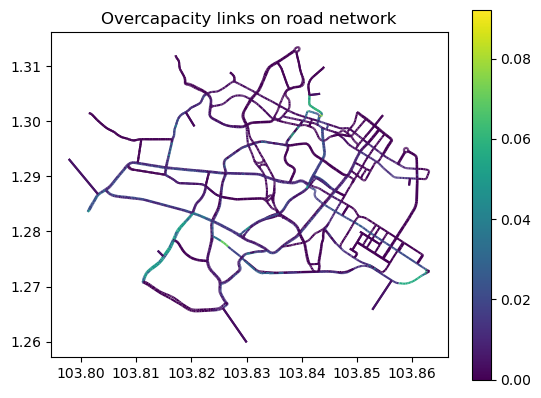

In [18]:
fig, ax = plt.subplots()
road_capacity_df.plot(ax=ax, column='demand/capacity', cmap='viridis', legend=True)
ax.set_title("Overcapacity links on road network")

In [15]:
# (5) Uses trip assignment outputs to inform impedance function of LUTI calculations
# Sets intrazonal travel time to fixed values of 5/10/15 minutes for drive/bike/walk respectively
# Caps maximum travel time at 90 minutes and minimum travel time at 1 minute
cijs = {}
cijs['DRIVE'] = load_cij(od_matrix=road_tt.pivot(index='Origin', columns='Destination', values='TT'),
                         intrazonal_tt=pd.DataFrame({"ZONE_CODE": zone_codes,
                                                     "TT": [5 for x in zone_codes]}),
                         zone_codes=zone_codes,
                         upper_threshold=90.0,
                         lower_threshold=1.0)
cijs['BIKE'] = load_cij(od_matrix=bike_tt.pivot(index='Origin', columns='Destination', values='TT'),
                        intrazonal_tt=pd.DataFrame({"ZONE_CODE": zone_codes,
                                                    "TT": [10 for x in zone_codes]}),
                        zone_codes=zone_codes,
                        upper_threshold=90.0,
                        lower_threshold=1.0)
cijs['WALK'] = load_cij(od_matrix=walk_tt.pivot(index='Origin', columns='Destination', values='TT'),
                        intrazonal_tt= pd.DataFrame({"ZONE_CODE": zone_codes,
                                                     "TT": [15 for x in zone_codes]}),
                        zone_codes=zone_codes,
                        upper_threshold= 90.0,
                        lower_threshold= 1.0)

Sij, Beta, CBarPred = runCalculationsSimple(ODs=od_matrices, cijs=cijs,
                                            df_Employment=dat[['ZONE_CODE', 'BASELINE_JOBS']],
                                            df_Residential= dat[['ZONE_CODE', 'BASELINE_POPULATION']],
                                            attractor='BASELINE_POPULATION',
                                            control='BASELINE_JOBS',
                                            convergence_criteria=0.2)

luti = luti_outputSimple(Sij=Sij,
                         data_input=dat,
                         production_var='BASELINE_POPULATION',
                         attraction_var='BASELINE_JOBS')

Text(0.5, 1.0, 'Population change')

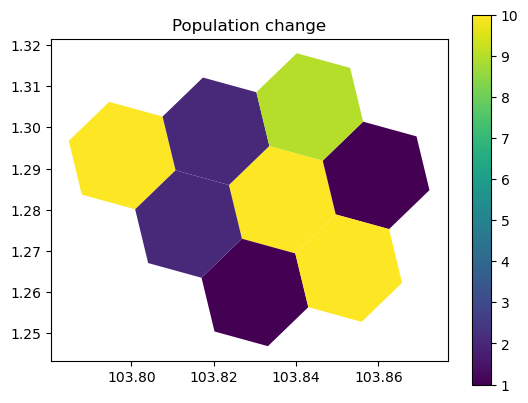

In [20]:
luti['POP_CHANGE'] = luti['NEW_POPULATION'] - luti['BASELINE_POPULATION']
map = dat[['ZONE_CODE', 'geometry']].merge(luti[['ZONE_CODE', 'POP_CHANGE']], on='ZONE_CODE')

fig, ax = plt.subplots()
map.plot(column='POP_CHANGE', cmap='viridis', legend=True, ax=ax)
ax.set_title("Population change")